In [70]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum, isnan, to_timestamp, mean, max, min, expr, when,lit
import matplotlib.pyplot as plt
import pandas as pd


# Sources 
- https://mungingdata.com/python/writing-parquet-pandas-pyspark-koalas/
- https://sparkbyexamples.com/pyspark/pyspark-dataframe-shape/
- https://sparkbyexamples.com/pyspark/pyspark-drop-column-from-dataframe/
- https://www.programmingfunda.com/how-to-count-null-and-nan-values-in-each-column-in-pyspark-dataframe/
- https://stackoverflow.com/questions/59969378/how-do-i-calculate-the-percentage-of-none-or-nan-values-in-pyspark
- https://sparkbyexamples.com/spark/show-top-n-rows-in-spark-pyspark/?expand_article=1

In [3]:
# creating spark session
spark = SparkSession.builder.getOrCreate()
# reading taxi data 
df = spark.read.csv("yellow_taxi_data.csv", header = True, inferSchema = True)

23/07/26 11:58:13 WARN Utils: Your hostname, MacBook-Air-3.local resolves to a loopback address: 127.0.0.1; using 192.168.0.227 instead (on interface en0)
23/07/26 11:58:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/26 11:58:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/07/26 11:58:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
# first 5 rows 
df.show(n = 5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2022-04-01 00:21:13|  2022-04-01 00:58:33|            1.0|         10.3|       1.0|                 N|         163|          62|           1|       33.5|  3.0|    0.5|      7.4

In [5]:
# shape of data frame
columns = len(df.columns)
rows = df.count()
print(f"There are {columns} columns and {rows} rows in this data frame")

There are 19 columns and 46576654 rows in this data frame


In [6]:
# dropping irrelevant columns 
irrelevant_columns = ["VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type", "fare_amount", "extra",
                      "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount",
                     "congestion_surcharge", "airport_fee"]

df = df.drop(*irrelevant_columns)

In [7]:
# new data frame shape
columns = len(df.columns)
rows = df.count()
print(f"There are {columns} columns and {rows} rows in this data frame")

There are 6 columns and 46576654 rows in this data frame


In [8]:
# first 5 rows 
df.show(n = 5)

+--------------------+---------------------+---------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|
+--------------------+---------------------+---------------+-------------+------------+------------+
| 2022-04-01 00:21:13|  2022-04-01 00:58:33|            1.0|         10.3|         163|          62|
| 2022-04-01 00:07:47|  2022-04-01 00:19:12|            0.0|          2.0|         142|         141|
| 2022-04-01 00:14:52|  2022-04-01 00:23:43|            1.0|          1.0|          79|         148|
| 2022-04-01 00:30:02|  2022-04-01 00:45:06|            1.0|          2.6|          79|          13|
| 2022-04-01 00:48:40|  2022-04-01 01:03:34|            1.0|         2.79|         238|         116|
+--------------------+---------------------+---------------+-------------+------------+------------+
only showing top 5 rows



In [9]:
# number of null rows in each column
df.select([count(when(col(column_name).isNull(), column_name)).alias(column_name) for column_name in df.columns]).show()



+--------------------+---------------------+---------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|
+--------------------+---------------------+---------------+-------------+------------+------------+
|                   0|                    0|        1532979|            0|           0|           0|
+--------------------+---------------------+---------------+-------------+------------+------------+



In [10]:
# percentage of missing rows in each column
null_percent = df.select([(count(when(col(c).isNull(), c))/count(lit(1))).alias(c) for c in df.columns])
null_percent.show()

+--------------------+---------------------+-------------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|    passenger_count|trip_distance|PULocationID|DOLocationID|
+--------------------+---------------------+-------------------+-------------+------------+------------+
|                 0.0|                  0.0|0.03291303407067412|          0.0|         0.0|         0.0|
+--------------------+---------------------+-------------------+-------------+------------+------------+



- Only the passenger_count column has missing rows 

# Analysing Each Column
## Sources
- https://sparkbyexamples.com/pyspark/pyspark-count-distinct-from-dataframe/#:~:text=In%20PySpark%2C%20you%20can%20use,count%20of%20records%20on%20DataFrame.
- https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
- https://sparkbyexamples.com/pyspark/pyspark-isin-and-in-operator/
- https://sparkbyexamples.com/spark/spark-and-or-not-operators/
- https://stackoverflow.com/questions/39383557/show-distinct-column-values-in-pyspark-dataframe
- https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page
- https://sparkbyexamples.com/pyspark/pyspark-groupby-explained-with-example/?expand_article=1#
- https://notebook.community/GoogleCloudDataproc/cloud-dataproc/notebooks/python/3.1.%20Spark%20DataFrame%20&%20Pandas%20Plotting%20-%20Python
- https://docs.kanaries.net/tutorials/PySpark/pyspark-dataframe-column-list
- https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
- https://sparkbyexamples.com/pyspark/pyspark-max-different-methods-explained/?expand_article=1
- https://sparkbyexamples.com/spark/pyspark-to_timestamp-convert-string-to-timestamp-type/

## Pickup  and Dropoff Locations

In [11]:
# number of unique pickup locations
pickup_locations = "PULocationID" 
num_unique_pickups = df.select(pickup_locations).distinct().count()
print(f"There are {num_unique_pickups} unique pickup locations")

There are 262 unique pickup locations


In [12]:
# number of unique dropoff locations 
dropoff_locations = "DOLocationID" 
num_unique_dropoffs = df.select(dropoff_locations).distinct().count()
print(f"There are {num_unique_dropoffs} unique dropoff locations")

There are 262 unique dropoff locations


- The number of unique pickup and drop off locations do not exceed the permitted number which is 263 according to taxi zones csv file retrieved from NYC open. 

### Manhattan Zones

In [13]:
# list of manhattan taxi zones retrieved from taxi zones csv file
manhattan = [4,24,12,13,41,45,42,43,48,50,68,79,74,75,87,88,90,125,100,103,107,113,114,116,120,127,128,151,140,137
             ,141,142,152,143,144,148,153,158,161,162,163,164,170,166,186,194,202,209,211,224,229,230,231,239,232
             ,233,234,236,237,238,243,244,246,249,261,262,263]

In [14]:
# number of zones in Manhattan
print(len(manhattan))

67


In [15]:
# number of pickups in Manhattan
manhattan_pu = df.filter(col("PULocationID").isin(manhattan))

In [16]:
# shape of manhattan pickup data frame
manhattan_pu_columns = len(manhattan_pu.columns)
manhattan_pu_rows = manhattan_pu.count()
print(f"There are {manhattan_pu_columns} columns and {manhattan_pu_rows} rows in this data frame")

There are 6 columns and 41388431 rows in this data frame


In [17]:
# number of dropoffs in Manhattan
manhattan_do = df.filter(col("DOLocationID").isin(manhattan))

In [18]:
# shape of manhattan dropoff data frame
manhattan_do_columns = len(manhattan_do.columns)
manhattan_do_rows = manhattan_do.count()
print(f"There are {manhattan_do_columns} columns and {manhattan_do_rows} rows in this data frame")

There are 6 columns and 41141402 rows in this data frame


- There are more more pickups in Manhattan than dropoffs, however dropoffs may be a better indicator of busyness because it represents people that are currently in Manhattan while pickups represent people that are leaving Manhattan

### Filtering to get rows with pickups or dropoffs in Manhattan

In [19]:
manhattan_df = df.filter(col("PULocationID").isin(manhattan) | col("DOLocationID").isin(manhattan))

In [20]:
# shape of filtered data frame
manhattan_columns = len(manhattan_df.columns)
manhattan_rows = manhattan_df.count()
print(f"There are {manhattan_columns} columns and {manhattan_rows} rows in this data frame")

There are 6 columns and 44132589 rows in this data frame


In [21]:
# first 5 rows
manhattan_df.show(n = 5)

+--------------------+---------------------+---------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|
+--------------------+---------------------+---------------+-------------+------------+------------+
| 2022-04-01 00:21:13|  2022-04-01 00:58:33|            1.0|         10.3|         163|          62|
| 2022-04-01 00:07:47|  2022-04-01 00:19:12|            0.0|          2.0|         142|         141|
| 2022-04-01 00:14:52|  2022-04-01 00:23:43|            1.0|          1.0|          79|         148|
| 2022-04-01 00:30:02|  2022-04-01 00:45:06|            1.0|          2.6|          79|          13|
| 2022-04-01 00:48:40|  2022-04-01 01:03:34|            1.0|         2.79|         238|         116|
+--------------------+---------------------+---------------+-------------+------------+------------+
only showing top 5 rows



In [22]:
# number of null rows in manhattan dataframe 
manhattan_df.select([count(when(col(column_name).isNull(), column_name)).alias(column_name) 
                     for column_name in manhattan_df.columns]).show()


+--------------------+---------------------+---------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|
+--------------------+---------------------+---------------+-------------+------------+------------+
|                   0|                    0|        1443046|            0|           0|           0|
+--------------------+---------------------+---------------+-------------+------------+------------+



In [23]:
# percentage of null rows in manhattan dataframe 
null_percent = manhattan_df.select([(count(when(col(c).isNull(), c))/count(lit(1))).alias(c) for c in manhattan_df.columns])
null_percent.show()

+--------------------+---------------------+--------------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|     passenger_count|trip_distance|PULocationID|DOLocationID|
+--------------------+---------------------+--------------------+-------------+------------+------------+
|                 0.0|                  0.0|0.032697968387941166|          0.0|         0.0|         0.0|
+--------------------+---------------------+--------------------+-------------+------------+------------+



- The amount of null rows in the passenger_count column has decrease slightly as a result of the filter

## Passenger Count 
### Irregular values

In [24]:
# distinct values in the passenger_count column
manhattan_df.select("passenger_count").distinct().collect()

[Row(passenger_count=8.0),
 Row(passenger_count=0.0),
 Row(passenger_count=7.0),
 Row(passenger_count=1.0),
 Row(passenger_count=4.0),
 Row(passenger_count=3.0),
 Row(passenger_count=2.0),
 Row(passenger_count=6.0),
 Row(passenger_count=5.0),
 Row(passenger_count=9.0),
 Row(passenger_count=None)]

In [25]:
# number of instance for each values
value_count = manhattan_df.groupBy("passenger_count").count().show()

+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|            8.0|      73|
|            0.0|  824011|
|            7.0|     109|
|            1.0|31656453|
|            4.0|  782595|
|            3.0| 1685594|
|            2.0| 6521298|
|            6.0|  488200|
|            5.0|  731188|
|            9.0|      22|
|           null| 1443046|
+---------------+--------+



In [26]:
# each trip should have at least 1 passengers
# according to the nyc.gov website, there should be no more that 6 passengers in a taxi
# list of irrelgular values
irregular_values =  [0.0, 7.0, 8.0, 9.0]

In [27]:
# total number of rows with irregular values
total_irregular = manhattan_df.filter(col("passenger_count").isin(irregular_values)).count()
print(f"The total number of rows with irregular passenger count is {total_irregular}")
# total number of rows
total_rows = manhattan_df.count()
# percentage of rows with irregular values
irregular_percent = (total_irregular/total_rows) * 100
print(f"The percentage of rows with irregular values is {irregular_percent}%")

The total number of rows with irregular passenger count is 824215


The percentage of rows with irregular values is 1.8675881444435538%


#### Plotting values

In [28]:
# converting the first 400000(almost 10% of the data set) rows in the passenger count column to a pandas data frame
passenger_pandas = manhattan_df.select("passenger_count").limit(400000).toPandas()["passenger_count"]

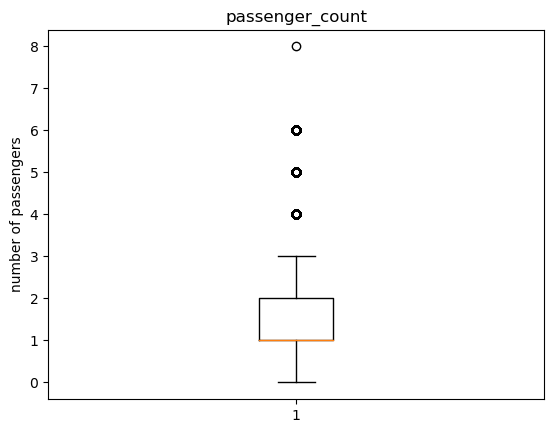

In [29]:
# box plot
plt.boxplot(passenger_pandas)
# plot title
plt.title("passenger_count")
# y axis label
plt.ylabel("number of passengers")
plt.show()

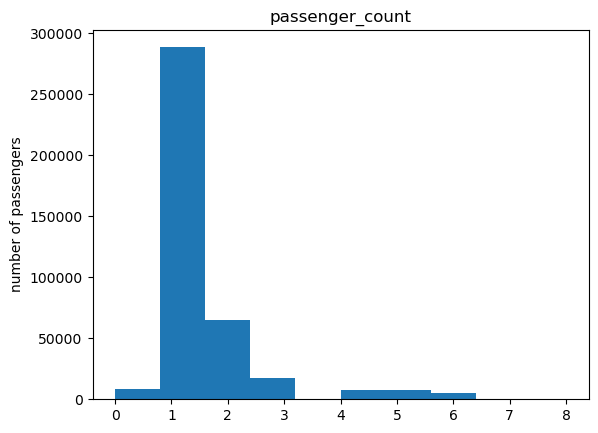

In [30]:
# histogram
plt.hist(passenger_pandas)
# plot title
plt.title("passenger_count")
# y axis label
plt.ylabel("number of passengers")
plt.show()

## Trip Distance

In [31]:
# max, min and mean distances 
distances = manhattan_df.select(max("trip_distance").alias("max distance"), 
                                min("trip_distance").alias("min distance"),
                               mean("trip_distance").alias("mean distance")).show()

+------------+------------+-----------------+
|max distance|min distance|    mean distance|
+------------+------------+-----------------+
|   389678.46|         0.0|5.273092328437684|
+------------+------------+-----------------+



In [32]:
# converting trip distance column to a pandas data frame using the first 400000 rows
distance_pandas = manhattan_df.select("trip_distance").limit(400000).toPandas()["trip_distance"]

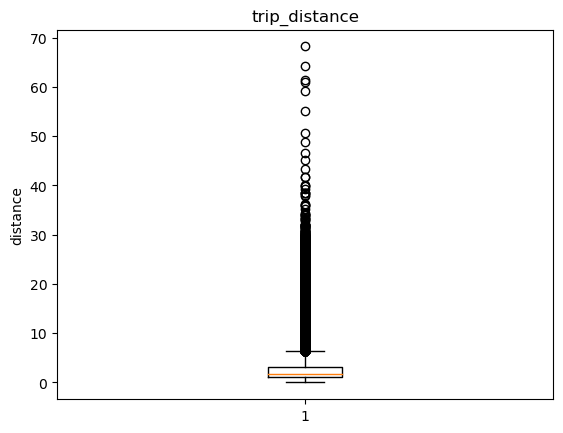

In [33]:
# box plot
plt.boxplot(distance_pandas)
# plot title
plt.title("trip_distance")
# y axis label
plt.ylabel("distance")
plt.show()

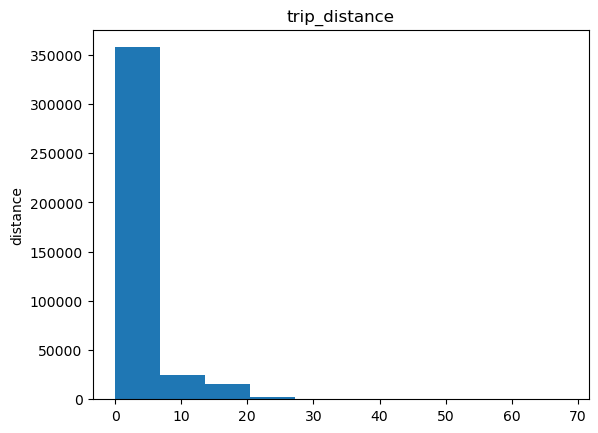

In [34]:
# histogram
plt.hist(distance_pandas)
# plot title
plt.title("trip_distance")
# y axis label
plt.ylabel("distance")
plt.show()

- Based on the plots, most of the trip distance is within 30 miles 

### Trips over 30 miles

In [35]:
# number of trips over 30 miles
distance = "trip_distance"
long_distance = manhattan_df.filter(col(distance) > 30).count()

print(f"The number of trips over 30 miles is {long_distance}")

The number of trips over 30 miles is 9090


In [36]:
# total number of rows
total_rows = manhattan_df.count()
# percentage of trips over 30 miles 
long_distance_percent = (long_distance/total_rows) * 100
print(f"The percentage of trips over 30 miles is {long_distance_percent}%")

The percentage of trips over 30 miles is 0.020597024117483795%


### Trips with a distance of 0.0 miles

In [37]:
# number of trips with 0 miles
zero_miles = manhattan_df.filter(col(distance) == 0.0).count()

print(f"The number of trips with 0 miles is {zero_miles}")

The number of trips with 0 miles is 428295


In [38]:
# percentage of trips with 0 miles 
zero_miles_percent = (zero_miles/total_rows) * 100
print(f"The percentage of trips with 0 miles is {zero_miles_percent}%")

The percentage of trips with 0 miles is 0.9704733162153709%


In [39]:
## the percentage of trips with 0 miles plus the percentage of trips over 30 miles 
total_zero_long_distance = zero_miles_percent + long_distance_percent
print(f"The percentage sum of trips over 30 miles and trips with 0 miles is {total_zero_long_distance}%")

The percentage sum of trips over 30 miles and trips with 0 miles is 0.9910703403328547%


## Dropoff and Pickup Times

In [40]:
# converting time columns to timestamp data type
# pickup time
manhattan_df = manhattan_df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
# dropoff time
manhattan_df = manhattan_df.withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))

In [41]:
# data types
manhattan_df.dtypes

[('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'double'),
 ('trip_distance', 'double'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int')]

In [42]:
# min and max pickup times
pickup_times = manhattan_df.select(max("tpep_pickup_datetime").alias("max pickup time"), 
                                min("tpep_pickup_datetime").alias("min pickup time")
                                  ).show()

+-------------------+-------------------+
|    max pickup time|    min pickup time|
+-------------------+-------------------+
|2023-04-18 14:30:05|2001-01-01 00:03:14|
+-------------------+-------------------+



In [43]:
# min and max dropoff times
dropoff_times = manhattan_df.select(max("tpep_dropoff_datetime").alias("max dropoff time"), 
                                min("tpep_dropoff_datetime").alias("min dropoff time")
                                  ).show()

+-------------------+-------------------+
|   max dropoff time|   min dropoff time|
+-------------------+-------------------+
|2023-04-18 23:30:39|2001-01-01 00:34:17|
+-------------------+-------------------+



- The minimum and maximum dropoff and pickup timestamp are outside the permitted range. The minimum timestamp should be 2022-02-01 00:00:00 and the maximum timestamp should be 2023-03-10 23:59:59 (last date in the subway data set) 

### Permitted timestamp range 

In [44]:
# correct timestamp range that matches with the subway data 
start_date = "2022-02-01 00:00:00"
end_date = "2023-03-10 23:59:59"

In [45]:
manhattan_df.dtypes

[('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'double'),
 ('trip_distance', 'double'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int')]

In [46]:
# number of rows within the permitted range 
correct_timestamp = manhattan_df.filter(
    (col("tpep_pickup_datetime") >= start_date) & (col("tpep_dropoff_datetime") <= end_date) & 
    (col("tpep_dropoff_datetime") >= start_date) & (col("tpep_dropoff_datetime") <= end_date)
)

correct_rows = correct_timestamp.count()                               
print(f"There are {correct_rows} rows within the permitted timestamp range")                                        
                                        

There are 41985057 rows within the permitted timestamp range


In [47]:
# number of rows outsitde the permitted range
incorrect_timestamp = manhattan_df.filter(
    ~(
    (col("tpep_pickup_datetime") >= start_date) & (col("tpep_dropoff_datetime") <= end_date) 
& (col("tpep_dropoff_datetime") >= start_date) & (col("tpep_dropoff_datetime") <= end_date)
    )
)

incorrect_rows = incorrect_timestamp.count()                               
print(f"There are {incorrect_rows} rows outside the permitted timestamp range")                                        
     

There are 2147532 rows outside the permitted timestamp range


In [48]:
# percentage of rows outside the permitted range
incorrect_date_percent = (incorrect_rows/total_rows) * 100
print(f"The percentage of rows outside the permitted timstamp range is {incorrect_date_percent}%")

The percentage of rows outside the permitted timstamp range is 4.866091132790782%


# Addressing Data Quality Issues 
## Sources
- https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/amp/
- https://sparkbyexamples.com/pyspark/pyspark-replace-column-values/?expand_article=1
- https://mungingdata.com/apache-spark/exact-percentile-approx-median/
- https://sparkbyexamples.com/pyspark/pyspark-fillna-fill-replace-null-values/?expand_article=1#

## Pickup and Dropoff Times

- Rows outside the permitted timestamp range will be removed. They cannot be replaced the mean because it can't be calculated due to the data type. Replacing with the mode or median may introduce bias for a certain day and time which may have an impact on the model since the rows outside of the permitted date and time range make up almost 5% of the data set


In [49]:
# filtering for rows within the permittted timestamp range
manhattan_df =  manhattan_df.filter(
    (col("tpep_pickup_datetime") >= start_date) & (col("tpep_dropoff_datetime") <= end_date) & 
    (col("tpep_dropoff_datetime") >= start_date) & (col("tpep_dropoff_datetime") <= end_date)
)


In [50]:
# max and mini pickup and dropoff times
times = manhattan_df.select(max("tpep_pickup_datetime").alias("max pickup time"),
                            min("tpep_pickup_datetime").alias("min pickup time"),
                            max("tpep_dropoff_datetime").alias("max dropoff time"), 
                                min("tpep_dropoff_datetime").alias("min dropoff time")
                                  ).show()

+-------------------+-------------------+-------------------+-------------------+
|    max pickup time|    min pickup time|   max dropoff time|   min dropoff time|
+-------------------+-------------------+-------------------+-------------------+
|2023-03-10 23:59:43|2022-02-01 00:00:00|2023-03-10 23:59:59|2022-02-01 00:01:31|
+-------------------+-------------------+-------------------+-------------------+



## Trip Distance
- The rows with distances over 30 miles and distance of 0 miles will be imputed with the median value
- Although these rows make up less than 1% of the data, the imputation will be done to preserve the data.
- The median value will be used because the mean may be affected by the outliers present in this column. The data is also skewed so 
- This imputation will likely not have significant impact on the data

In [51]:
# median distance
median_distance = df.agg(expr("percentile(trip_distance, 0.5)").alias("median")).first()["median"]
print(median_distance)

1.88


In [52]:
# replacing trips over 30 miles with the median trip distance
manhattan_df = manhattan_df.withColumn("trip_distance", when(col("trip_distance")
                                                             >= 30, median_distance).otherwise(col("trip_distance")))

In [53]:
# replacing trips with 0 miles with the median trip distance
manhattan_df = manhattan_df.withColumn("trip_distance", when(col("trip_distance")
                                                             == 0.0, median_distance).otherwise(col("trip_distance")))

In [54]:
# min and max distance
distances = manhattan_df.select(max("trip_distance").alias("max distance"), 
                                min("trip_distance").alias("min distance"),
                              ).show()

+------------+------------+
|max distance|min distance|
+------------+------------+
|       29.99|        0.01|
+------------+------------+



## Passenger Count

In [55]:
# number of null rows
passenger_null = manhattan_df.filter(col("passenger_count").isNull()).count()
print(f"The number of null passenger count rows is  {passenger_null}")

The number of null passenger count rows is  1386363


In [56]:
# percentage of null rows
passenger_null_percent = (passenger_null/total_rows) * 100
print(f"The percentage of null passenger count rows is {passenger_null_percent}%")

The percentage of null passenger count rows is 3.1413588720117915%


In [57]:
# number of instance for each values
value_count = manhattan_df.groupBy("passenger_count").count().show()

+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|            8.0|      70|
|            0.0|  786957|
|            7.0|     103|
|            1.0|30077648|
|            4.0|  743067|
|            3.0| 1607352|
|            2.0| 6212397|
|            6.0|  469970|
|            5.0|  701109|
|            9.0|      21|
|           null| 1386363|
+---------------+--------+



In [58]:
# total number of rows with irregular values
total_irregular = manhattan_df.filter(col("passenger_count").isin(irregular_values)).count()
print(f"The total number of rows with irregular passenger count is {total_irregular}")
# total number of rows
total_rows = manhattan_df.count()
# percentage of rows with irregular values
irregular_percent = (total_irregular/total_rows) * 100
print(f"The percentage of rows with irregular values is {irregular_percent}%")

The total number of rows with irregular passenger count is 787151


The percentage of rows with irregular values is 1.874836087515613%


In [59]:
# median passenger count
median_passenger = df.agg(expr("percentile(passenger_count, 0.5)").alias("median")).first()["median"]
print(median_passenger)

1.0


- As shown above the percentage of rows with irregular values and number of null rows has decreased. This can be attributed to the fact that some rows were removed to address other data quality issues
- The remaining rows will be replaced with 1 since this is median passenger count as show above. 
- 1 also is smallest permitted value for this column so it will be used to replace the rows with irregular values and null rows in an effort to preserve the data.
- This may introduce some bias into the data however impact will likely not be significant because the rows being replaced make up just over 5% so this imputation is unlikely to impact the prediction model.

In [60]:
# null rows 
manhattan_df = manhattan_df.na.fill(median_passenger,["passenger_count"])

In [61]:
# number of null rows
passenger_null = manhattan_df.filter(col("passenger_count").isNull()).count()
print(f"The number of null passenger count rows is  {passenger_null}")

The number of null passenger count rows is  0


- The null rows have be filled 

In [62]:
## irregular values greater than or equal to 7
manhattan_df = manhattan_df.withColumn("passenger_count", when(col("passenger_count")
                                                             >= 7, median_passenger).otherwise(col("passenger_count")))

In [63]:
## irregular values equal to 0.0
manhattan_df = manhattan_df.withColumn("passenger_count", when(col("passenger_count")
                                                             == 0.0, median_passenger).otherwise(col("passenger_count")))

In [64]:
# total number of rows with irregular values
total_irregular = manhattan_df.filter(col("passenger_count").isin(irregular_values)).count()
print(f"The total number of rows with irregular passenger count is {total_irregular}")
# total number of rows
total_rows = manhattan_df.count()
# percentage of rows with irregular values
irregular_percent = (total_irregular/total_rows) * 100
print(f"The percentage of rows with irregular values is {irregular_percent}%")

The total number of rows with irregular passenger count is 0


The percentage of rows with irregular values is 0.0%


In [65]:
# number of instances of each distinct value in the passenger count column
value_count = manhattan_df.groupBy("passenger_count").count().show()

+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|            1.0|32251162|
|            4.0|  743067|
|            3.0| 1607352|
|            2.0| 6212397|
|            6.0|  469970|
|            5.0|  701109|
+---------------+--------+



- There are no more columns with irregular passenger count values, the data set cleaning is now complete

In [66]:
# shape of cleaned data frame
columns = len(manhattan_df.columns)
rows = manhattan_df.count()
print(f"There are {columns} columns and {rows} rows in this data frame")

There are 6 columns and 41985057 rows in this data frame


In [67]:
# first 5 rows of cleaned data frame
manhattan_df.show(n = 5)

+--------------------+---------------------+---------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|
+--------------------+---------------------+---------------+-------------+------------+------------+
| 2022-04-01 00:21:13|  2022-04-01 00:58:33|            1.0|         10.3|         163|          62|
| 2022-04-01 00:07:47|  2022-04-01 00:19:12|            1.0|          2.0|         142|         141|
| 2022-04-01 00:14:52|  2022-04-01 00:23:43|            1.0|          1.0|          79|         148|
| 2022-04-01 00:30:02|  2022-04-01 00:45:06|            1.0|          2.6|          79|          13|
| 2022-04-01 00:48:40|  2022-04-01 01:03:34|            1.0|         2.79|         238|         116|
+--------------------+---------------------+---------------+-------------+------------+------------+
only showing top 5 rows



## Data Quality Summary
| Variable Names                     | Data Quality Issue            | Handling Strategy              |
|------------------------------------|-------------------------------|--------------------------------|
| RatecodeID                          | Irrelevant        | Drop column                   |
| store_and_fwd_flag                    | Irrelevant        | Drop column                       |
| payment_type                         | Irrelevant         | Drop column                       |
| fare_amount                  | Irrelevant        | Drop column                       |
| extra                          | Irrelevant|Drop column        |
| mta_tax                                | Irrelevant| Drop column         |
| tip_amount                               | Irrelevant| Drop column        |
| tolls_amount                          | Irrelevant| Drop column        |
| improvement_surcharge    | Irrelevant                     | Drop column|
| total_amount                | Irrelevant                      | Drop column|
| airport_fee                        | Irrelevant | Drop column                         |
| VendorID                     | Irrelevant, constant values |Drop column       |
| congestion_surcharge                            | Irrelevant|Drop column       |
| passenger_count                           |null rows, invalid values |Impute null rows and rows with irregular values with median|
| trip_distance                           |Outliers |Impute rows with 0 miles and rows with distances over 30 miles with median    |
| tpep_pickup_datetime         | Invalid values                    |Remove all with inccorect dates - Cannot calculate mean so can't be filled in with that value, can't be filled in with random values. Using next neigbour(previous value/ next value), median or mode could inflate busyness count
       |
| tpep_dropoff_datetime        | Inavlid values                   |Remove all with inccorect dates - Cannot calculate mean so can't be filled in with that value, can't be filled in with random values. Using next neigbour(previous value/ next value), median or mode could inflate busyness count
      |



In [117]:
# saving data frame as a csv file 
manhattan_df.coalesce(1).write.csv("cleaned_taxi.csv", header = True)

In [119]:
# saving data frame as a parquet file 
manhattan_df.coalesce(1).write.parquet("cleaned_taxi.parquet")


In [71]:
# reading saved parquet files as a pandas data frame
df = pd.read_parquet("cleaned_taxi.parquet")